In [1]:
from __future__ import print_function
import torchvision
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
###############
import torchvision.models as models
import imageio
from torch import autograd
from torchvision.utils import make_grid
import imageio
from IPython.display import HTML
import time
import math
manualseed = 47
random.seed(manualseed)
torch.manual_seed(manualseed)
import torch.nn.functional as F
###############
%matplotlib inline

2 Define variables

In [2]:
workers = 2 # 数据加载器能够使用的进程数量
batch_size = 64  # 训练时的批大小
weight_decay = 1e-5
# 训练图片的大小，所有的图片都将改变到该大小
image_size = 32  # 转换器使用的大小.
nc = 3  # 训练图片的通道数，彩色图片是3
nz = 100  # 本征向量z的大小(生成器的输入大小)
ngf = 32  # 生成器中特征图个数大小
ndf = 64  # 判别器中特征图个数大小
num_epochs = 50
lr = 0.0002  # 优化器学习率
beta1 = 0.5  # Adam优化器的Beta1超参
ngpu = 1  # 可利用的GPU数量，使用0将运行在CPU模式。
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

3 创建数据集

In [3]:
from torch.utils.data import Dataset, DataLoader

class Generator1(nn.Module):
    def __init__(self, ngf = 32):
        super(Generator1,self).__init__()
        self.gen=nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(200, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输入特征图大小. (nc) x 32 x 32
        )
    def forward(self, x):
        x=self.gen(x)
        return x





class FakeNumberDataset(Dataset):
    def __init__(self, dataset_name="mnist",transform=None):
        """
            mix_ratio: real/fake
        """

        if dataset_name=="mnist":
            odataset = datasets.MNIST('MNIST_data', train=True, transform=transform)
        elif dataset_name=="fashion_mnist":
            odataset = datasets.FashionMNIST('MNIST_data', train=True, transform=transform)
        elif dataset_name=="cifar10":
            odataset = datasets.CIFAR10('MNIST_data', train=True, transform=transform)
        elif dataset_name=="cifar100":
            odataset = datasets.CIFAR100('MNIST_data', train=True, transform=transform)
        else:
            print("Wrong argument for dataset_name!")
            return None
    


        self.label = []
        self.items = []
        ############################
        n_z=100
        ############################
        #target_num = mix_ratio * fake_images.shape[0]
        #self.added_real = 0 
#         print(len(odataset))
   
        netG1 = Generator1().to(device)
        netG1.load_state_dict(torch.load('C:\\Users\\lz172\\Desktop\\CIFAR100\\netG_params.pkl'))
        for idx in range(len(odataset)):
            x_idx, y_idx = odataset[idx]
#             print(x_idx)
#             if y_idx:
#                 self.items.append(x_idx)
#                 self.label.append(y_idx)
            if y_idx:
                noise1 = torch.randn(1, 100)
                labels_onehot1 = np.zeros((1,100))
                labels_onehot1[np.arange(1),y_idx]=1 # 这个9换成想生成的数字
                noise1=np.concatenate((noise1.cpu().numpy(), labels_onehot1),axis=1)
                # 每张图片是0到9之间的数字
                labels_onehot1 = Variable(torch.from_numpy(labels_onehot1).float())
#                 labels_onehot = Variable(torch.from_numpy(labels_onehot).float())
                noise1=noise1.reshape([-1, 200, 1, 1])
                noise1=Variable(torch.from_numpy(noise1).float())                
                fake_image1 = netG1(noise1.to(device)).detach().cpu()
                fake_image_first = torch.squeeze(fake_image1,0)
                #######第二个假图片######
                noise2 = torch.randn(1, 100)
                labels_onehot2 = np.zeros((1,100))
                labels_onehot2[np.arange(1),y_idx]=1 # 这个9换成想生成的数字
                noise2=np.concatenate((noise2.cpu().numpy(), labels_onehot2),axis=1)
                # 每张图片是0到9之间的数字
                labels_onehot2 = Variable(torch.from_numpy(labels_onehot2).float())
#                 labels_onehot = Variable(torch.from_numpy(labels_onehot).float())
                noise2=noise2.reshape([-1, 200, 1, 1])
                noise2=Variable(torch.from_numpy(noise2).float())                
                fake_image2 = netG1(noise2.to(device)).detach().cpu()
                fake_image_second = torch.squeeze(fake_image2,0)
                ########################
                a1 = torch.rand(1)
                a2 = torch.rand(1)
                lamma1 = min(a1,a2)
                lamma2 = abs(a1-a2)
                lamma3 = 1-max(a1,a2)
#                 x_idx = (a1*0.25+0.25)*x_idx + (0.75-a1*0.25)*fake_image_first
                x_idx = x_idx   
                
#                 x_idx = lamma1*x_idx + lamma2*fake_image_first+lamma3*fake_image_second
#                 print(x_idx.shape)
#                 x_idx = fake_image
                self.items.append(x_idx)
                self.label.append(y_idx)

            ##############################################
            
             

    def checkAddedRealImgs(self):
        return self.added_real
    
    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.items[idx], self.label[idx]

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        self.ngpu = ngpu
        super(Generator,self).__init__()
        self.gen=nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(200, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输入特征图大小. (nc) x 32 x 32
        )
    def forward(self, x):
        x=self.gen(x)
        return x

In [6]:

# 创建生成器
netG = Generator(ngpu).to(device)

# 如果期望使用多个GPU，设置一下。
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 使用权重初始化函数 weights_init 去随机初始化所有权重
#  mean=0, stdev=0.2.
netG.apply(weights_init)

# 输出该模型
print(netG)


Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(200, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(3, ngf, 4, 2, 1, bias=False),  #这里源码的输入1通道需要改成3通道
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*2) x 16 x 16
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*2) x 8 x 8
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*4) x 4 x 4
            nn.Conv2d(ngf * 4, 101, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [8]:

# 创建判别器
netD = Discriminator(ngpu).to(device)

# 如果期望使用多GPU，设置一下
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 使用权重初始化函数 weights_init 去随机初始化所有权重
#  mean=0, stdev=0.2.
netD.apply(weights_init)

# 输出该模型
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 101, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [9]:

# 初始化 BCE损失函数
criterion = nn.BCELoss()
criterion_pic = nn.CrossEntropyLoss()
# 创建一个批次的本征向量用于可视化生成器训练的过程。
fixed_noise = torch.randn(64, nz + 100, 1, 1, device=device)

# 建立一个在训练中使用的真实和假的标记
real_label = 1
fake_label = 0

# 为G和D都设置Adam优化器 # 刚看到说G的lr是D的lr的2倍会好一些
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [10]:
transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Mnist or FashionMnist
train_dataset_with_fake = FakeNumberDataset(dataset_name="cifar100",transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset_with_fake, batch_size=64, shuffle=True) 

# 训练循环




# 保存跟踪进度的列表
img_list = []
G_losses = []
D_losses = []
iters = 0
errD_real = float(0)
print("Starting Training Loop...")
# 每个epoh
for epoch in range(num_epochs):
    # 数据加载器中的每个批次
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) 更新 D 网络: 最大化 log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## 使用所有真实样本批次训练
        netD.zero_grad()
        # 格式化批
#         real_cpu = data[0].to(device)
#         data = Variable(data)
#         data = data.to(device)
        
        real_cpu = data[0].to(device)
        ############reshape real_cpu###########
#         real_cpu = torch.cat((real_cpu,real_cpu,real_cpu),1)
        #######################################
        
#         print(real_cpu.shape)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device,dtype=torch.float)
        
        
#         print(real_cpu.shape)
        # 通过D向前传递真实批次的feature map
        output = netD(real_cpu)
#         print(output.shape)
        output = output.view(b_size,101)
#         print(output.shape)
        # output = output.view([b_size, 11]　　　　　
        real_label_label = output[:, 0]  # 第一维就是预测是否是真实图片
        real_label_pic = output[:, 1:]  # 后十维是onehot，判断是哪个数字
#         print(real_label_pic.shape)
        # 对所有真实样本批次计算损失
#         print(label.shape)
#         print(real_label_label.shape)
        errD_real = criterion(real_label_label, label)
        errD_real.backward(retain_graph=True)  # 连续多个backward，除了最后一个不叫retain_graph=True,其余都要加

        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device))
        errD_fake_pic.backward()

        # 计算后向传递中D的梯度

        D_x = real_label_label.mean().item()

        ## 使用所有假样本批次训练
        # 生成本征向量批次
        #   noise = torch.randn(b_size, nz+10, 1, 1, device=device)  # 注释这行表示输入110维的noise，也就是DCGAN的输入
        noise = torch.randn(b_size, nz, device=device)

        labels_onehot = np.zeros((b_size, 100))
        labels_onehot[np.arange(b_size), data[1].numpy()] = 1
        noise = np.concatenate((noise.cpu().numpy(), labels_onehot), axis=1)
        # 每张图片是0到9之间的数字
        labels_onehot = Variable(torch.from_numpy(labels_onehot).float()).to(device)
        noise = noise.reshape([-1, 200, 1, 1])
        noise = Variable(torch.from_numpy(noise).float()).to(device)

        # 使用生成器G生成假图片
        fake = netG(noise)
        label.fill_(fake_label)                               
        
        
        
    
        
        
        # 使用判别器分类所有的假批次样本的feature map
        output = netD(fake.detach())
        # 计算判别器D的损失对所有的假样本批次
        #         output = output.view([b_size, 11])
        output = output.view([b_size, 101])
        real_label_label = output[:, 0]
        real_label_pic = output[:, 1:]
        errD_fake = criterion(real_label_label, label)
        # 对这个批次计算梯度
        errD_fake.backward(retain_graph=True)
        
#         errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) + 0.2*loss1
        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) 
        errD_fake_pic.backward(retain_graph=True)
        D_G_z1 = real_label_label.mean().item()
        # 把所有真样本和假样本批次的梯度加起来
        errD = errD_real + errD_fake + errD_fake_pic 
        # 更新判别器D
        optimizerD.step()

        ############################
        # (2) 更新 G 网络: 最大化 log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 假样本的标签对于生成器成本是真的
        # 因为我们之更新了D，通过D执行所有假样本批次的正向传递
        output = netD(fake).view(-1) #这里是将netD的输入fake换成了fake_feature
        # 基于这个输出计算G的损失
        output = output.view([b_size, 101])
        real_label_label = output[:, 0]
        real_label_pic = output[:, 1:]
        errG = criterion(real_label_label, label)
        # 为生成器计算梯度
        errG.backward(retain_graph=True)
#         errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) + 0.2*loss1
        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) 
        errD_fake_pic.backward()
        D_G_z2 = output.mean().item()
        # 更新生成器G
        optimizerG.step()

        # 输出训练状态
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 为以后画损失图，保存损失
        G_losses.append(errG.item())
        D_losses.append(errD.item())
#         print(0)

        # 检查生成器generator做了什么，通过保存的fixed_noise通过G的输出
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
print("Congratulations! Training Finished!")

Starting Training Loop...
[0/50][0/774]	Loss_D: 6.0774	Loss_G: 1.2346	D(x): 0.4382	D(G(z)): 0.4211 / 0.4787
[0/50][50/774]	Loss_D: 5.1933	Loss_G: 3.1664	D(x): 0.7545	D(G(z)): 0.2669 / 0.3745
[0/50][100/774]	Loss_D: 4.9580	Loss_G: 3.9554	D(x): 0.8242	D(G(z)): 0.1384 / 0.3464
[0/50][150/774]	Loss_D: 5.4800	Loss_G: 3.2986	D(x): 0.7074	D(G(z)): 0.3494 / 0.3575
[0/50][200/774]	Loss_D: 5.0781	Loss_G: 2.9256	D(x): 0.7714	D(G(z)): 0.1986 / 0.3378
[0/50][250/774]	Loss_D: 4.8783	Loss_G: 3.8915	D(x): 0.8794	D(G(z)): 0.0961 / 0.3337
[0/50][300/774]	Loss_D: 5.5784	Loss_G: 1.3603	D(x): 0.5973	D(G(z)): 0.3245 / 0.3364
[0/50][350/774]	Loss_D: 5.3979	Loss_G: 2.0414	D(x): 0.6563	D(G(z)): 0.2387 / 0.3322
[0/50][400/774]	Loss_D: 5.3548	Loss_G: 2.2496	D(x): 0.6367	D(G(z)): 0.2256 / 0.3110
[0/50][450/774]	Loss_D: 5.6875	Loss_G: 2.0058	D(x): 0.6105	D(G(z)): 0.3782 / 0.3187
[0/50][500/774]	Loss_D: 5.1397	Loss_G: 2.9430	D(x): 0.7601	D(G(z)): 0.1551 / 0.3019
[0/50][550/774]	Loss_D: 5.3991	Loss_G: 3.3727	D(x): 0

[6/50][50/774]	Loss_D: 5.0427	Loss_G: 1.2897	D(x): 0.5680	D(G(z)): 0.3500 / 0.1622
[6/50][100/774]	Loss_D: 5.0905	Loss_G: 1.2034	D(x): 0.6571	D(G(z)): 0.4828 / 0.1696
[6/50][150/774]	Loss_D: 5.0853	Loss_G: 1.8282	D(x): 0.6483	D(G(z)): 0.4650 / 0.1522
[6/50][200/774]	Loss_D: 5.1008	Loss_G: 1.0503	D(x): 0.5665	D(G(z)): 0.3951 / 0.1556
[6/50][250/774]	Loss_D: 4.9538	Loss_G: 1.7260	D(x): 0.7607	D(G(z)): 0.4956 / 0.1487
[6/50][300/774]	Loss_D: 5.0289	Loss_G: 1.2158	D(x): 0.4886	D(G(z)): 0.2544 / 0.1482
[6/50][350/774]	Loss_D: 4.8196	Loss_G: 1.6115	D(x): 0.7106	D(G(z)): 0.4173 / 0.1525
[6/50][400/774]	Loss_D: 5.0542	Loss_G: 0.8989	D(x): 0.4676	D(G(z)): 0.2732 / 0.1424
[6/50][450/774]	Loss_D: 4.9457	Loss_G: 0.8757	D(x): 0.5222	D(G(z)): 0.2637 / 0.1471
[6/50][500/774]	Loss_D: 4.8210	Loss_G: 1.4824	D(x): 0.6826	D(G(z)): 0.3979 / 0.1473
[6/50][550/774]	Loss_D: 4.9051	Loss_G: 1.3053	D(x): 0.6330	D(G(z)): 0.3703 / 0.1429
[6/50][600/774]	Loss_D: 4.8419	Loss_G: 1.1853	D(x): 0.6353	D(G(z)): 0.3321 / 

[12/50][100/774]	Loss_D: 4.7953	Loss_G: 1.1422	D(x): 0.6305	D(G(z)): 0.3554 / 0.1255
[12/50][150/774]	Loss_D: 4.5437	Loss_G: 1.5605	D(x): 0.6507	D(G(z)): 0.2224 / 0.1107
[12/50][200/774]	Loss_D: 4.9623	Loss_G: 1.3665	D(x): 0.5873	D(G(z)): 0.3737 / 0.1184
[12/50][250/774]	Loss_D: 4.6516	Loss_G: 1.4365	D(x): 0.6888	D(G(z)): 0.3578 / 0.1081
[12/50][300/774]	Loss_D: 5.1359	Loss_G: 0.4320	D(x): 0.4374	D(G(z)): 0.2857 / 0.1119
[12/50][350/774]	Loss_D: 4.6204	Loss_G: 1.4183	D(x): 0.5865	D(G(z)): 0.1839 / 0.1172
[12/50][400/774]	Loss_D: 4.9242	Loss_G: 1.3622	D(x): 0.5710	D(G(z)): 0.3476 / 0.1231
[12/50][450/774]	Loss_D: 4.9110	Loss_G: 1.8777	D(x): 0.6888	D(G(z)): 0.4633 / 0.1165
[12/50][500/774]	Loss_D: 4.6471	Loss_G: 1.6505	D(x): 0.7419	D(G(z)): 0.3624 / 0.1073
[12/50][550/774]	Loss_D: 4.6418	Loss_G: 1.2146	D(x): 0.6410	D(G(z)): 0.2651 / 0.1111
[12/50][600/774]	Loss_D: 4.9377	Loss_G: 1.1611	D(x): 0.5170	D(G(z)): 0.3054 / 0.1120
[12/50][650/774]	Loss_D: 4.6277	Loss_G: 1.8032	D(x): 0.7883	D(G(z

[18/50][100/774]	Loss_D: 5.3164	Loss_G: 1.8560	D(x): 0.7104	D(G(z)): 0.6173 / 0.0977
[18/50][150/774]	Loss_D: 4.7880	Loss_G: 1.3712	D(x): 0.6313	D(G(z)): 0.3805 / 0.0887
[18/50][200/774]	Loss_D: 4.5450	Loss_G: 1.9062	D(x): 0.8523	D(G(z)): 0.4342 / 0.0883
[18/50][250/774]	Loss_D: 4.7335	Loss_G: 1.5193	D(x): 0.6117	D(G(z)): 0.3233 / 0.0958
[18/50][300/774]	Loss_D: 4.8885	Loss_G: 0.8999	D(x): 0.4837	D(G(z)): 0.2666 / 0.0948
[18/50][350/774]	Loss_D: 4.9533	Loss_G: 1.2565	D(x): 0.5131	D(G(z)): 0.3492 / 0.0977
[18/50][400/774]	Loss_D: 4.8027	Loss_G: 1.2633	D(x): 0.5712	D(G(z)): 0.2764 / 0.0962
[18/50][450/774]	Loss_D: 5.2859	Loss_G: 0.8316	D(x): 0.3958	D(G(z)): 0.3236 / 0.0923
[18/50][500/774]	Loss_D: 4.8647	Loss_G: 1.4842	D(x): 0.7912	D(G(z)): 0.5226 / 0.0962
[18/50][550/774]	Loss_D: 4.9811	Loss_G: 1.3474	D(x): 0.6700	D(G(z)): 0.4965 / 0.0963
[18/50][600/774]	Loss_D: 5.1451	Loss_G: 1.1350	D(x): 0.3230	D(G(z)): 0.0885 / 0.0917
[18/50][650/774]	Loss_D: 4.9711	Loss_G: 1.1640	D(x): 0.6024	D(G(z

[24/50][100/774]	Loss_D: 4.7883	Loss_G: 1.2905	D(x): 0.6892	D(G(z)): 0.4310 / 0.0913
[24/50][150/774]	Loss_D: 4.9455	Loss_G: 1.0315	D(x): 0.5895	D(G(z)): 0.4180 / 0.0841
[24/50][200/774]	Loss_D: 4.6735	Loss_G: 1.6980	D(x): 0.6280	D(G(z)): 0.3267 / 0.0917
[24/50][250/774]	Loss_D: 4.7855	Loss_G: 2.1530	D(x): 0.7424	D(G(z)): 0.4742 / 0.0814
[24/50][300/774]	Loss_D: 4.7949	Loss_G: 1.3650	D(x): 0.6100	D(G(z)): 0.3296 / 0.0866
[24/50][350/774]	Loss_D: 5.1598	Loss_G: 1.8259	D(x): 0.7316	D(G(z)): 0.6040 / 0.0924
[24/50][400/774]	Loss_D: 4.6811	Loss_G: 1.6826	D(x): 0.6273	D(G(z)): 0.3211 / 0.0906
[24/50][450/774]	Loss_D: 4.5855	Loss_G: 1.6364	D(x): 0.7521	D(G(z)): 0.3896 / 0.0901
[24/50][500/774]	Loss_D: 4.8971	Loss_G: 1.2783	D(x): 0.4454	D(G(z)): 0.1852 / 0.0922
[24/50][550/774]	Loss_D: 4.9928	Loss_G: 1.4632	D(x): 0.6806	D(G(z)): 0.5064 / 0.0856
[24/50][600/774]	Loss_D: 4.8985	Loss_G: 0.9383	D(x): 0.5116	D(G(z)): 0.2940 / 0.0846
[24/50][650/774]	Loss_D: 4.6276	Loss_G: 1.4611	D(x): 0.6198	D(G(z

[30/50][100/774]	Loss_D: 4.8817	Loss_G: 1.4488	D(x): 0.7919	D(G(z)): 0.5309 / 0.0816
[30/50][150/774]	Loss_D: 4.7114	Loss_G: 1.3060	D(x): 0.6923	D(G(z)): 0.4013 / 0.0769
[30/50][200/774]	Loss_D: 4.7063	Loss_G: 1.4179	D(x): 0.6534	D(G(z)): 0.3677 / 0.0821
[30/50][250/774]	Loss_D: 4.8980	Loss_G: 1.5627	D(x): 0.5758	D(G(z)): 0.3871 / 0.0729
[30/50][300/774]	Loss_D: 4.8255	Loss_G: 2.1587	D(x): 0.7645	D(G(z)): 0.5107 / 0.0745
[30/50][350/774]	Loss_D: 5.0385	Loss_G: 1.7694	D(x): 0.7432	D(G(z)): 0.5690 / 0.0799
[30/50][400/774]	Loss_D: 4.6429	Loss_G: 1.2676	D(x): 0.6212	D(G(z)): 0.2903 / 0.0832
[30/50][450/774]	Loss_D: 5.0280	Loss_G: 1.8350	D(x): 0.7708	D(G(z)): 0.5737 / 0.0788
[30/50][500/774]	Loss_D: 4.8513	Loss_G: 1.0928	D(x): 0.6235	D(G(z)): 0.4135 / 0.0770
[30/50][550/774]	Loss_D: 4.7050	Loss_G: 1.2078	D(x): 0.6488	D(G(z)): 0.3527 / 0.0829
[30/50][600/774]	Loss_D: 4.8593	Loss_G: 1.6354	D(x): 0.6245	D(G(z)): 0.3830 / 0.0774
[30/50][650/774]	Loss_D: 4.8245	Loss_G: 2.1904	D(x): 0.8053	D(G(z

[36/50][100/774]	Loss_D: 4.6575	Loss_G: 1.6053	D(x): 0.7419	D(G(z)): 0.3939 / 0.0753
[36/50][150/774]	Loss_D: 4.6537	Loss_G: 1.2976	D(x): 0.5230	D(G(z)): 0.1721 / 0.0700
[36/50][200/774]	Loss_D: 4.5604	Loss_G: 1.4028	D(x): 0.7342	D(G(z)): 0.3568 / 0.0718
[36/50][250/774]	Loss_D: 4.9659	Loss_G: 1.2596	D(x): 0.5720	D(G(z)): 0.3992 / 0.0758
[36/50][300/774]	Loss_D: 4.8390	Loss_G: 1.6970	D(x): 0.7034	D(G(z)): 0.4393 / 0.0782
[36/50][350/774]	Loss_D: 5.2981	Loss_G: 2.4324	D(x): 0.7338	D(G(z)): 0.6544 / 0.0720
[36/50][400/774]	Loss_D: 4.6626	Loss_G: 1.0610	D(x): 0.5910	D(G(z)): 0.2215 / 0.0801
[36/50][450/774]	Loss_D: 4.5256	Loss_G: 2.0356	D(x): 0.8012	D(G(z)): 0.4074 / 0.0727
[36/50][500/774]	Loss_D: 4.7529	Loss_G: 1.0460	D(x): 0.5416	D(G(z)): 0.2790 / 0.0745
[36/50][550/774]	Loss_D: 4.5584	Loss_G: 1.6680	D(x): 0.7215	D(G(z)): 0.3282 / 0.0697
[36/50][600/774]	Loss_D: 5.0970	Loss_G: 1.5246	D(x): 0.6440	D(G(z)): 0.5452 / 0.0786
[36/50][650/774]	Loss_D: 4.6323	Loss_G: 1.2612	D(x): 0.6115	D(G(z

[42/50][100/774]	Loss_D: 4.5678	Loss_G: 1.5322	D(x): 0.6057	D(G(z)): 0.2389 / 0.0696
[42/50][150/774]	Loss_D: 4.6642	Loss_G: 1.6827	D(x): 0.6274	D(G(z)): 0.2856 / 0.0673
[42/50][200/774]	Loss_D: 4.7281	Loss_G: 1.4609	D(x): 0.6258	D(G(z)): 0.3158 / 0.0695
[42/50][250/774]	Loss_D: 4.6548	Loss_G: 1.5338	D(x): 0.6901	D(G(z)): 0.3694 / 0.0725
[42/50][300/774]	Loss_D: 4.8246	Loss_G: 1.6579	D(x): 0.7576	D(G(z)): 0.4987 / 0.0743
[42/50][350/774]	Loss_D: 4.4886	Loss_G: 2.2319	D(x): 0.8262	D(G(z)): 0.3782 / 0.0693
[42/50][400/774]	Loss_D: 4.9380	Loss_G: 1.3598	D(x): 0.4555	D(G(z)): 0.2390 / 0.0671
[42/50][450/774]	Loss_D: 4.5303	Loss_G: 1.6546	D(x): 0.6265	D(G(z)): 0.2000 / 0.0715
[42/50][500/774]	Loss_D: 4.6299	Loss_G: 1.5919	D(x): 0.7121	D(G(z)): 0.3644 / 0.0701
[42/50][550/774]	Loss_D: 4.5224	Loss_G: 2.1623	D(x): 0.8458	D(G(z)): 0.4186 / 0.0714
[42/50][600/774]	Loss_D: 4.8199	Loss_G: 2.1021	D(x): 0.7854	D(G(z)): 0.5253 / 0.0676
[42/50][650/774]	Loss_D: 4.4248	Loss_G: 1.8830	D(x): 0.7842	D(G(z

[48/50][100/774]	Loss_D: 4.9101	Loss_G: 1.5516	D(x): 0.4109	D(G(z)): 0.1401 / 0.0676
[48/50][150/774]	Loss_D: 4.6520	Loss_G: 1.5990	D(x): 0.6262	D(G(z)): 0.3092 / 0.0675
[48/50][200/774]	Loss_D: 4.8866	Loss_G: 1.1865	D(x): 0.6282	D(G(z)): 0.3937 / 0.0697
[48/50][250/774]	Loss_D: 4.6046	Loss_G: 1.6602	D(x): 0.6224	D(G(z)): 0.2675 / 0.0657
[48/50][300/774]	Loss_D: 4.6992	Loss_G: 1.5043	D(x): 0.6441	D(G(z)): 0.3417 / 0.0683
[48/50][350/774]	Loss_D: 4.2415	Loss_G: 2.6574	D(x): 0.8570	D(G(z)): 0.2701 / 0.0671
[48/50][400/774]	Loss_D: 4.6279	Loss_G: 1.8725	D(x): 0.7100	D(G(z)): 0.3653 / 0.0694
[48/50][450/774]	Loss_D: 4.6254	Loss_G: 1.2938	D(x): 0.6505	D(G(z)): 0.2700 / 0.0681
[48/50][500/774]	Loss_D: 5.0333	Loss_G: 0.8306	D(x): 0.4118	D(G(z)): 0.2052 / 0.0775
[48/50][550/774]	Loss_D: 4.3251	Loss_G: 1.9190	D(x): 0.7993	D(G(z)): 0.2677 / 0.0730
[48/50][600/774]	Loss_D: 4.6346	Loss_G: 2.2370	D(x): 0.8444	D(G(z)): 0.4752 / 0.0641
[48/50][650/774]	Loss_D: 4.7949	Loss_G: 1.4598	D(x): 0.5444	D(G(z

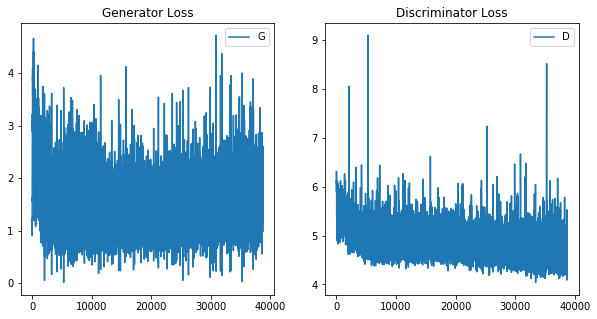

In [11]:
#Draw Losses
# 对照组
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Generator Loss")
plt.plot(G_losses,label="G")
plt.legend()
plt.subplot(1,2,2)
plt.title("Discriminator Loss")
plt.plot(D_losses,label="D")
# plt.plot(D_penalties,label="D_penalty")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
plt.legend()
plt.show()

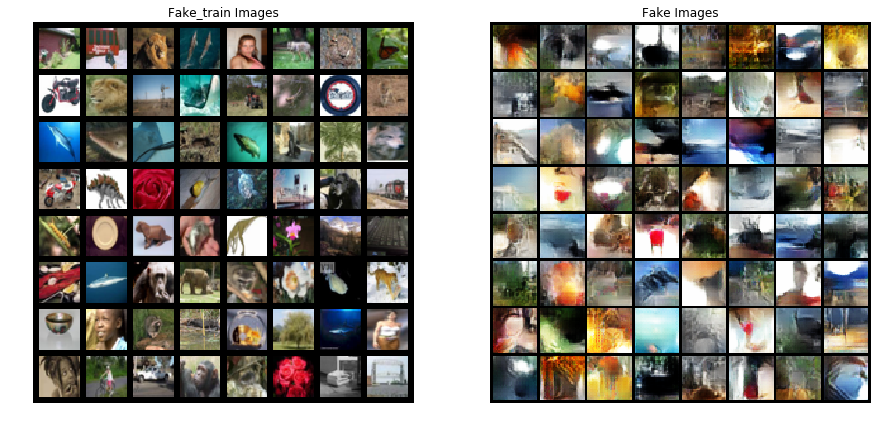

In [12]:
# 从数据加载器中获取一批真实图像
real_batch = next(iter(dataloader))

# 画出真实图像
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake_train Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 画出来自最后一次训练的假图像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


In [16]:
torch.save(netG.state_dict(), "C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\\saved-models\\CGAN-Clear-Generator-MaxLogVar48-epoch60-Fashion_MNIST-6\\netG_params.pkl")
torch.save(netD.state_dict(), "C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\\saved-models\\CGAN-Clear-Discriminator-MaxLogVar48-epoch60-Fashion_MNIST-6\\netD_params.pkl")
noise = torch.randn(b_size, nz, device=device)
        
labels_onehot = np.zeros((b_size,10))
labels_onehot[np.arange(b_size),2]=1 # 这个9换成想生成的数字
noise=np.concatenate((noise.cpu().numpy(), labels_onehot),axis=1)
# 每张图片是0到9之间的数字
labels_onehot = Variable(torch.from_numpy(labels_onehot).float()).to(device)
noise=noise.reshape([-1, 200, 1, 1])
# print(noise.shape)
noise=Variable(torch.from_numpy(noise).float()).to(device)

# 使用生成器G生成假图片
fake = netG(noise)
# fake = torch.squeeze((fake),0)
# print(fake.shape)
plt.imshow(fake.cpu().detach().numpy()[5][0])

ValueError: cannot reshape array of size 3080 into shape (200,1,1)